# Financial Markets project
DL and Applied AI at Sapienza 2021 

Author: Klaudia Palak and Hossein

## Dataset preparation

In [3]:
import numpy as np
import pandas as pd

import math

from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable

### Load data

In [4]:
df=pd.read_csv("TSLA.csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


Splitting data into training and test. 

The target value to be predicted is going to be the “Close” stock price value. 

In [5]:
df_close = df.iloc[:, [0,4]]
df_close.head(10)

,Date,Close
0,2015-07-10,51.830002
1,2015-07-13,52.431999
2,2015-07-14,53.130001
3,2015-07-15,52.627998
4,2015-07-16,53.335999
5,2015-07-17,54.931999
6,2015-07-20,56.452000
7,2015-07-21,53.354000
8,2015-07-22,53.574001
9,2015-07-23,53.439999


Let's visualize some data!

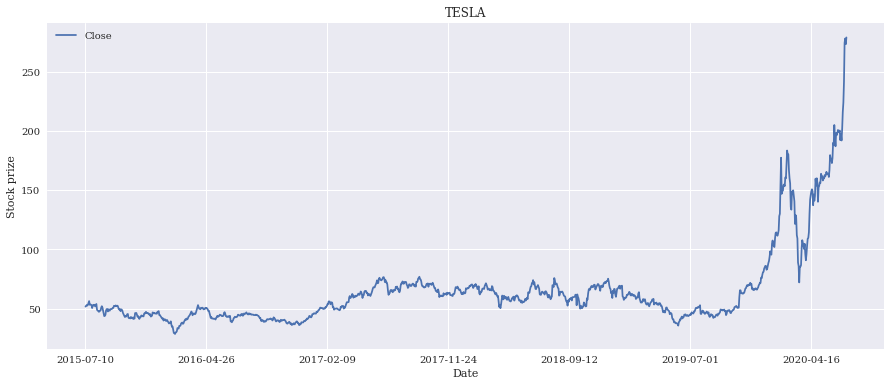

In [6]:
df_tesla = pd.DataFrame(df_close,columns=['Date','Close'])
df_tesla.plot(x ='Date', y='Close', figsize=(15,6))
plt.ylabel("Stock prize")
plt.title("TESLA")
plt.show()

In [7]:
df_tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Close   1259 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


### Normalization

But first, we should check if dataset has a null values and in case of existing this kind of values - fill it!

In [8]:
# ffill: propagate last valid observation forward to next valid backfill
df_tesla=df_tesla.fillna(method='ffill')

In [9]:
# checking if still I have a null column
print("Do I have a null column? \n", df_tesla.isna().sum())

Do I have a null column? 
 Date     0
Close    0
dtype: int64


In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# only for Close column
df_tesla = scaler.fit_transform(df_tesla['Close'].values.reshape(-1,1))

### Split data to train and test data

In [11]:
# training_size = int(len(df_tesla)*0.80)
# data_len = len(df_tesla)

# train, test = df_tesla[0:training_size], df_tesla[training_size:data_len]

In [12]:
#@title Timesteps for creating training data
timesteps = 20 #@param {type:"slider", min:10, max:100, step:10}

def load_data(stock, look_back):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

# def split_data(data, timesteps):
#   data_len = len(data)
#   X_data = []
#   y_data = []

#   for i in range(timesteps, data_len):
#       X_data.append(data[i - timesteps:i, 0])
#       y_data.append(data[i, 0])
#   X_data, y_data = np.array(X_data), np.array(y_data)
#   return [X_data, y_data]

# # for train data
# X_train, y_train = split_data(train, timesteps)
# # for test data
# X_test, y_test = split_data(test, timesteps)
X_train, y_train, X_test, y_test = load_data(df_tesla, timesteps)

In [13]:
# print("Total length of data --> ", data_len)
print("Train length --> ", len(X_train))
print("Test length --> ", len(X_test))

Train length -->  991
Test length -->  248


### Reshaping

In [14]:
# These 3 sizes are typically: The size of data we have, Number of steps (timesteps above chosen by us), Number of features.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("X_train --> ", X_train.shape)
print("y_train shape --> ", y_train.shape)
print("X_test --> ", X_test.shape)
print("y_test shape --> ", y_test.shape)

X_train -->  (991, 19, 1)
y_train shape -->  (991, 1)
X_test -->  (248, 19, 1)
y_test shape -->  (248, 1)


### Convert to tensors

In [15]:
# make training and test sets in torch
x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [16]:
y_train.size(), x_train.size()

(torch.Size([991, 1]), torch.Size([991, 19, 1]))

## Model

In [17]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


Constructor of the class accepts:

*   input_size: Corresponds to the number of features in the input. 
*   hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer.
*   output_size: The number of items in the output, since we want to predict the close price for the end of the day, the output size will be 1.






In [18]:
#@title Parameters of the Model
input_dim = 1 #@param {type:"integer"}
hidden_dim = 40 #@param {type:"integer"}
num_layers = 1 #@param {type:"integer"}
output_dim = 1 #@param {type:"integer"}

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # I just want last time step hidden states!!!!
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)
6
torch.Size([160, 1])
torch.Size([160, 40])
torch.Size([160])
torch.Size([160])
torch.Size([1, 40])
torch.Size([1])


## Train Model

In [19]:
#@title Timesteps for creating training data
num_epochs = 100 #@param {type:"slider", min:1, max:500, step:10}


# history
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =timesteps-1  

for t in range(num_epochs):
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    #every 10 epochs
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

     # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.035728927701711655
Epoch  20 MSE:  0.007807901594787836
Epoch  30 MSE:  0.006103678606450558
Epoch  40 MSE:  0.005644675809890032
Epoch  50 MSE:  0.005549919325858355
Epoch  60 MSE:  0.005436448846012354
Epoch  70 MSE:  0.005204646848142147
Epoch  80 MSE:  0.004925422370433807
Epoch  90 MSE:  0.004657441284507513


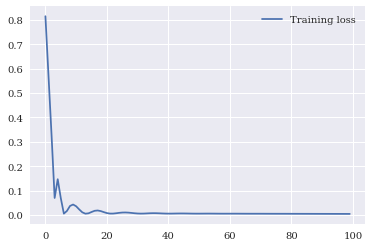

In [20]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [21]:
print(np.shape(y_train_pred))
print(np.shape(y_train))

torch.Size([991, 1])
torch.Size([991, 1])


In [22]:
# save the model
# checkpoint = {'model': LSTM(input_dim, hidden_dim, output_dim, num_layers),
#               'state_dict': model.state_dict(),
#               'optimizer' : optimiser.state_dict()}

torch.save(model, 'checkpoint.pth')

In [23]:
# load the model
loaded_model = torch.load('checkpoint.pth')

In [24]:
print(y_train_pred.shape)

torch.Size([991, 1])


In [25]:
# make predictions
# model.eval()
y_test_pred = loaded_model(x_test)

# invert predictions
# inverse_transform --> we normalized our data. converts these values ​​to before normalization.
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [26]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.29 RMSE
Test Score: 50.76 RMSE


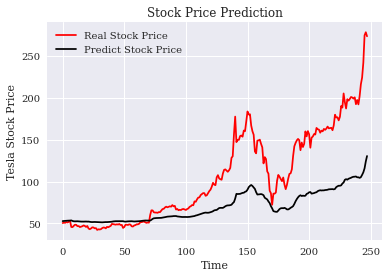

In [27]:
plt.plot(y_test, color = "red", label = "Real Stock Price")
plt.plot(y_test_pred, color = "black", label = "Predict Stock Price")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Tesla Stock Price")
plt.legend()
plt.show()